<a href="https://colab.research.google.com/github/SultanDaffaN/portfolio-sultan/blob/main/Traveloka%20Chatbot%20Model/Traveloka_Chatbot_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow import keras
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Setting the Params**

In [ ]:
NUM_WORDS = 500
EMBEDDING_DIM = 16
MAXLEN = 15
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

# **Reading the File**

In [ ]:
# import our chat-bot intents file
import json
with open('intents.json') as json_data:
    json_object = json.load(json_data)

In [ ]:
sentences = []
labels = []
uniqueLabels = []

for data in json_object['intents']:
  for pattern in data['patterns']:
    sentences.append(pattern)
    labels.append(data['tag'])
  if data['tag'] not in uniqueLabels:
    uniqueLabels.append(data['tag'])
  


for i in range(5):
  print('label: ', labels[i])
  print('pattern: ', sentences[i])
  print()

print('Total Unique Label:', len(uniqueLabels))

label:  opsi
pattern:  How you could help me?

label:  opsi
pattern:  What you can do?

label:  opsi
pattern:  What help you provide?

label:  opsi
pattern:  How you can be helpful?

label:  opsi
pattern:  What support is offered

Total Unique Label: 51


# **Preprocessing Texts**

## **Lowering Texts**

In [ ]:
# Lowering text
def lowering_texts(sentences):
  sentences_temp = []
  for sentence in sentences:
    sentences_temp.append(sentence.lower())

  sentences_temp
  return sentences_temp

sentences = lowering_texts(sentences)
sentences[:10]

['how you could help me?',
 'what you can do?',
 'what help you provide?',
 'how you can be helpful?',
 'what support is offered',
 'how to pay booking in indomaret',
 'how to pay booking in alfamart',
 'can i pay booking in indomaret',
 'can i pay booking in alfamart',
 'i want to pay booking in indomaret']

## **Remove Punctuations**

In [ ]:
PUNCTUATIONS = string.punctuation

# Remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))

sentences = [remove_punctuation(sentence) for sentence in sentences]
sentences[:10]

['how you could help me',
 'what you can do',
 'what help you provide',
 'how you can be helpful',
 'what support is offered',
 'how to pay booking in indomaret',
 'how to pay booking in alfamart',
 'can i pay booking in indomaret',
 'can i pay booking in alfamart',
 'i want to pay booking in indomaret']

## **Removing Stopwords**

In [ ]:
# Filtering using stopwords
def remove_stopwords(sentences):
  sentences_temp = []
  for sentence in sentences:
    for word in STOPWORDS:
      token = ' ' + word + ' '
      sentence = sentence.replace(token, ' ')
      sentence = sentence.replace(' ', ' ')
    sentences_temp.append(sentence)

  return sentences_temp

sentences = remove_stopwords(sentences)
sentences[:10]

['how could help me',
 'what do',
 'what help provide',
 'how helpful',
 'what support offered',
 'how pay booking indomaret',
 'how pay booking alfamart',
 'can pay booking indomaret',
 'can pay booking alfamart',
 'i want pay booking indomaret']

# **Splitting Data**

In [ ]:
import random

def train_val_split(sentences, labels, training_split):
    ### START CODE HERE
    sentLabels = list(zip(sentences, labels))
    random.Random(5).shuffle(sentLabels)
    sentences, labels = list(zip(*sentLabels)) 
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [ ]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 242 sentences for training.

There are 242 labels for training.

There are 61 sentences for validation.

There are 61 labels for validation.


# **Tokenizing and Padding Sentences**

In [ ]:
# FUNCTION: fit_tokenizer
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [ ]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(word_index)

Vocabulary contains 189 words

<OOV> token included in vocabulary
{'<OOV>': 1, 'how': 2, 'i': 3, 'booking': 4, 'hotel': 5, 'want': 6, 'eats': 7, 'pay': 8, 'what': 9, 'traveloka': 10, 'payment': 11, 'can': 12, 'voucher': 13, 'book': 14, 'flight': 15, 'account': 16, 'ticket': 17, 'train': 18, 'check': 19, 'refund': 20, 'installments': 21, 'get': 22, 'know': 23, 'reschedule': 24, 'cancel': 25, 'redeem': 26, 'where': 27, 'dont': 28, 'status': 29, 'paid': 30, 'coupon': 31, 'request': 32, 'solve': 33, 'find': 34, 'latest': 35, 'promos': 36, 'methods': 37, 'steps': 38, 'error': 39, 'wrong': 40, 'travel': 41, 'havent': 42, 'add': 43, 'is': 44, 'email': 45, 'expiration': 46, 'date': 47, 'transaction': 48, 'qr': 49, 'code': 50, 'travelokapay': 51, 'password': 52, 'reset': 53, 'villa': 54, 'why': 55, 'restaurant': 56, 'got': 57, 'select': 58, 'seat': 59, 'business': 60, 'otp': 61, 'verification': 62, 'received': 63, 'indomaret': 64, 'deactivate': 65, 'unlock': 66, 'my': 67, 'apartment': 68, 'use'

In [ ]:
# GRADED FUNCTION: seq_and_pad
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    
    ### END CODE HERE
    
    return padded_sequences

In [ ]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

print(f"First padded sequence of train:\n {train_padded_seq[0]}")
print(f"First padded sequence of val:\n {val_padded_seq[0]}")

Padded training sequences have shape: (242, 15)

Padded validation sequences have shape: (61, 15)
First padded sequence of train:
 [  2  76  77 128  16   0   0   0   0   0   0   0   0   0   0]
First padded sequence of val:
 [  3 112  23 132  82  16   0   0   0   0   0   0   0   0   0]


# **Tokenizing Labels**

In [ ]:
# GRADED FUNCTION: tokenize_labels
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    
    Returns:
        label_seq_np (array of int): tokenized labels
    """
    ### START CODE HERE
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq) - 1
   
    
    ### END CODE HERE
    
    return label_seq_np

In [ ]:
# Test your function
train_label_seq = tokenize_labels(uniqueLabels, train_labels)
val_label_seq = tokenize_labels(uniqueLabels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

print(f"uniqueLabels: \n {uniqueLabels}\n")
print(f"First 5 Labels before tokenize: \n{train_labels[:5]}\n")
print(f"First 5 Labels before tokenize: \n{val_labels[:5]}\n")

First 5 labels of the training set should look like this:
[[39]
 [45]
 [ 4]
 [18]
 [ 3]]

First 5 labels of the validation set should look like this:
[[11]
 [41]
 [12]
 [27]
 [26]]

Tokenized labels of the training set have shape: (242, 1)

Tokenized labels of the validation set have shape: (61, 1)

uniqueLabels: 
 ['opsi', 'payBookingIndoAlfa', 'scanQRCode', 'confirmationPayment', 'findPromos', 'payInstallments', 'deactivateAccount', 'unknownPasswordReset', 'addEmailHp', 'payBooking', 'checkPaymentStatus', 'travelokaBankAccount', 'unsuccessfulTransaction', 'resendOTP', 'unlockAccount', 'paidWrongAmount', 'eatsVoucherExpirationDate', 'eatsRefundDurationProcess', 'redeemEatsVoucher', 'restaurantRejectsEatsVoucher', 'eatsVoucherErrorRedemption', 'BookFlight', 'ActivateFlightPriceAlerts', 'PaySelectSeat', 'ReschedulingFlightHotelBooking', 'BookFlightHotel', 'confirmingTrainBooking', 'CancelAndGetRefundTrainBooking', 'TrainETicket', 'RescheduleRerouteTrainBooking', 'kaiTravelRegulationUpda

# **Creating the Model**

In [ ]:
# GRADED FUNCTION: create_model
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, 64, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=512, kernel_size=6, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(.6),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(len(uniqueLabels), activation='softmax')
    ])
    opt = tf.keras.optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model


In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=120, validation_data=(val_padded_seq, val_label_seq), callbacks=[earlystopping])

Epoch 1/120
8/8 [==============================] - 1s 59ms/step - loss: 3.9285 - accuracy: 0.0124 - val_loss: 3.9312 - val_accuracy: 0.0164
Epoch 2/120
8/8 [==============================] - 0s 35ms/step - loss: 3.9058 - accuracy: 0.0537 - val_loss: 3.9276 - val_accuracy: 0.0492
Epoch 3/120
8/8 [==============================] - 0s 57ms/step - loss: 3.8805 - accuracy: 0.0744 - val_loss: 3.9099 - val_accuracy: 0.0820
Epoch 4/120
8/8 [==============================] - 0s 58ms/step - loss: 3.8416 - accuracy: 0.1157 - val_loss: 3.8879 - val_accuracy: 0.1148
Epoch 5/120
8/8 [==============================] - 0s 57ms/step - loss: 3.7815 - accuracy: 0.1736 - val_loss: 3.8484 - val_accuracy: 0.1475
Epoch 6/120
8/8 [==============================] - 0s 51ms/step - loss: 3.7051 - accuracy: 0.2025 - val_loss: 3.7976 - val_accuracy: 0.1475
Epoch 7/120
8/8 [==============================] - 0s 53ms/step - loss: 3.5712 - accuracy: 0.2355 - val_loss: 3.7232 - val_accuracy: 0.1311
Epoch 8/120
8/8 [===

# **Evaluate the Model**

In [ ]:
predictions = model.predict(val_padded_seq)
predictions_classes = np.argmax(predictions,axis=1)
predictions_classes

2/2 [==============================] - 0s 9ms/step


array([11, 41, 12, 27, 26, 42, 45, 22, 22, 32, 11, 41,  2, 20, 10, 44, 33,
       28,  1, 22, 30, 14, 46, 15, 14, 24, 21, 12, 12, 47, 15,  0, 38, 10,
        9, 35, 10,  5, 11, 30, 13, 21, 33, 15,  1, 49,  8, 46, 29, 20, 38,
       29,  8, 11,  3, 19, 37,  2, 44, 28, 19])

In [ ]:
print(classification_report(val_label_seq, predictions_classes))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         3
          18       0.00      0.00      0.00         1
          19       1.00      1.00      1.00         2
          20       0.50      1.00      0.67         1
          21       1.00      1.00      1.00         2
          22       1.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Predicting Some Sentences**

In [ ]:
def predict_model(sentence):
  sentence_seq_pad = seq_and_pad(sentence, tokenizer, PADDING, MAXLEN)
  prediction = model.predict(sentence_seq_pad)
  percentage = {}
  for i in range(len(prediction[0])):
    percentage[uniqueLabels[i]] = prediction[0][i] 
  
  percentage = sorted(percentage.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)

  print(f"sentence: {sentence[0]} \n")
  print(f"sentence yang telah di olah: \n{sentence_seq_pad}\n")
  #print(f"Prediksi model: \n {prediction[0]}\n")
  print(f"5 Prediksi Teratas: \n {percentage[:5]}\n")
  print(f"Prediksi Label: {uniqueLabels[np.argmax(prediction[0])]} \n \n \n")

In [ ]:
predict_model(['transaction did not success'])
predict_model(['my account is locked'])
predict_model(['idk how to book a hotel'])
predict_model(['want to cancel train booking'])
predict_model(['book a train using e-ticket'])
predict_model(['what do you know?'])
predict_model(['I wanna add phone number'])
predict_model(['I want get coupon from traveloka'])

1/1 [==============================] - 0s 22ms/step
sentence: transaction did not success 

sentence yang telah di olah: 
[[48  1  1  1  0  0  0  0  0  0  0  0  0  0  0]]

5 Prediksi Teratas: 
 [('wrongTransferTraveloka', 0.18871388), ('opsi', 0.14030842), ('paymentSupportedTravelokaPay', 0.12818703), ('TrainETicket', 0.046058554), ('unsuccessfulTransaction', 0.04513929)]

Prediksi Label: wrongTransferTraveloka 
 
 

1/1 [==============================] - 0s 22ms/step
sentence: my account is locked 

sentence yang telah di olah: 
[[ 67  16  44 131   0   0   0   0   0   0   0   0   0   0   0]]

5 Prediksi Teratas: 
 [('unlockAccount', 0.8493431), ('mergeAccounts', 0.040861107), ('deactivateAccount', 0.031897034), ('refundRequestInInstallments', 0.015756892), ('paymentSupportedTravelokaPay', 0.014899393)]

Prediksi Label: unlockAccount 
 
 

1/1 [==============================] - 0s 23ms/step
sentence: idk how to book a hotel 

sentence yang telah di olah: 
[[ 1  2  1 14  1  5  0  0  0  

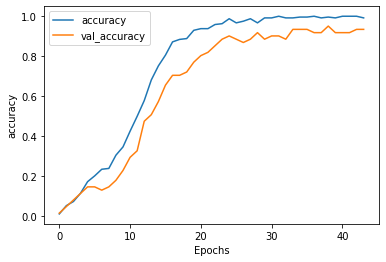

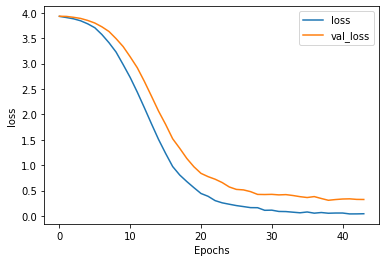

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# **Saving the Tokenizer and the Model**

In [ ]:
# Saving model and Tokenizer
import pickle

def saving_tokenizer_model(tokenizer, model):
  # Saving Tokenizer
  with open('tokenizer.pickle', 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  # Saving Model
  keras_model_path = './chatbot-model.h5'
  model.save(keras_model_path)

  

In [ ]:
saving_tokenizer_model(tokenizer, model)

# **Loading the Tokenizer and the Model**

In [ ]:
# Loading Tokenizer and Model
def load_tokenizer_model(tokenizer_file, model_file):
  # loading tokenizer
  with open(tokenizer_file, 'rb') as handle:
      tokenizer = pickle.load(handle)

  model = keras.models.load_model(model_file)

  return tokenizer, model

In [ ]:
tokenizer_load, model_load = load_tokenizer_model('tokenizer.pickle','chatbot-model.h5')

# **Predicting Sentences using The Load Model**

In [ ]:
def predict_model_load(sentence, model,tokenizer, PADDING, MAXLEN):
  sentence_seq_pad = seq_and_pad(sentence, tokenizer, PADDING, MAXLEN)
  prediction = model.predict(sentence_seq_pad)
  labels = uniqueLabels
  percentage = {}
  for i in range(len(prediction[0])):
    percentage[labels[i]] = prediction[0][i] 
  
  percentage = sorted(percentage.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)

  print(f"sentence: {sentence[0]} \n")
  print(f"sentence yang telah di olah: \n{sentence_seq_pad}\n")
  #print(f"Prediksi model: \n {prediction[0]}\n")
  print(f"5 Prediksi Teratas: \n {percentage[:5]}\n")
  print(f"Prediksi Label: {labels[np.argmax(prediction[0])]} \n \n \n")

In [ ]:
# Coba Menggunakan tokenizer load dan model load
predict_model_load(['I want to deactivate my account'], model_load, tokenizer_load, 'post', 15)

1/1 [==============================] - 0s 22ms/step
sentence: I want to deactivate my account 

sentence yang telah di olah: 
[[ 3  6  1 65 67 16  0  0  0  0  0  0  0  0  0]]

5 Prediksi Teratas: 
 [('deactivateAccount', 0.5696074), ('unlockAccount', 0.3732964), ('payBookingIndoAlfa', 0.017691499), ('registerAccessTravelokaPay', 0.012142715), ('RescheduleRerouteTrainBooking', 0.004046761)]

Prediksi Label: deactivateAccount 
 
 

